In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.notebook import trange, tqdm
import yaml
%matplotlib notebook
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# TODO:
1. Add kinematic visocisty
2. Backport velocity diffusion to DFSPH code (own module)
3. IMPROVE PERFORMANCE
4. Add drag forces
5. delta sph with boundary integrals?!
6. setup dambreak with obstacle
7. setup flow past cylinder
8. add wcsph (müller)
9. add compressible sph
10. setup shockwave scenario for compressible sph

In [3]:
# from src.deltaSPH import deltaSPHSimulation

In [4]:
from src.deltaSPH import deltaSPHSimulation
from src.dfsph import dfsphSimulation

def loadConfig(config):
    with open(config, 'r') as file:
        tomlConfig = file.read()
    parsedConfig = tomli.loads(tomlConfig)
    simulationScheme = 'deltaSPH'
    if 'simulation' in parsedConfig:
        if 'scheme' in parsedConfig['simulation']:
            simulationScheme = parsedConfig['simulation']['scheme']
            
    if simulationScheme == 'deltaSPH' or simulationScheme == 'deltaPlus':
        return parsedConfig, deltaSPHSimulation
    if simulationScheme == 'dfsph':
        return parsedConfig, dfsphSimulation
    

In [5]:
velocities = []

r = 2
for i in range(8):
#     for j in range(8):
    theta_i = 2 * np.pi * i / 8
    xi = r * np.cos(theta_i)
    yi = r * np.sin(theta_i)
    
    velocities.append(np.array([xi,yi]))
    
#     debugPrint(xi)
debugPrint(velocities)

velocities [list] = [array([2., 0.]), array([1.41421356, 1.41421356]), array([1.2246468e-16, 2.0000000e+00]), array([-1.41421356,  1.41421356]), array([-2.0000000e+00,  2.4492936e-16]), array([-1.41421356, -1.41421356]), array([-3.6739404e-16, -2.0000000e+00]), array([ 1.41421356, -1.41421356])]


In [6]:

# def loadConfig(config, i, j):
#     with open(config, 'r') as file:
#         tomlConfig = file.read()
#     parsedConfig = tomli.loads(tomlConfig)
    
#     parsedConfig['emitter']['fluidL']['velocity'] = velocities[i]
#     parsedConfig['emitter']['fluidR']['velocity'] = velocities[j]
#     parsedConfig['export']['prefix'] = 'collision %d x %d' %(i,j)
#     parsedConfig['export']['active'] = False
    
#     simulationScheme = 'deltaSPH'
#     if 'simulation' in parsedConfig:
#         if 'scheme' in parsedConfig['simulation']:
#             simulationScheme = parsedConfig['simulation']['scheme']
            
#     if simulationScheme == 'deltaSPH' or simulationScheme == 'deltaPlus':
#         return parsedConfig, deltaSPHSimulation
#     if simulationScheme == 'dfsph':
#         return parsedConfig, dfsphSimulation

In [7]:
config = 'configs/dambreak_dfsph.toml'
config = 'configs/collision_dfsph.toml'
config = 'configs/generative.toml'
# config = 'configs/collision2_dfsph.toml'
# config = 'configs/oscillating_drop_deltasph.toml'
# parsedConfig, simulationModel = loadConfig(config,2,2)
parsedConfig, simulationModel = loadConfig(config)

In [8]:
sphSimulation = simulationModel(parsedConfig)

Computed radius based on dx  0.031746031746031744  for nx =  64
radius:  0.017798838052399454
area:  0.0009952522675736961
support:  0.12585679
packing:  0.25223933099870244


In [9]:
sphSimulation.initializeSimulation()

ptcls: 4096
domainPtcls: 804
centerPtcls: 0


/home/winchenbach/dev/pytorchSPH2/src/modules/solidBoundary.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bNormals.append(torch.tensor(domainSDFDer, device = self.device, dtype = self.dtype))


In [10]:

# from plotting import *
plt.style.use('default')
# plt.style.use('default')
from tqdm.notebook import trange, tqdm

In [11]:
# positions = sphSimulation.simulationState['fluidPosition']
# velocities = sphSimulation.simulationState['fluidVelocity']

# sigma = 1

# velocities[:,0] = sigma * positions[:,0]
# velocities[:,1] = -sigma * positions[:,1]

In [12]:
sphSimulation.perennialState = sphSimulation.saveState()
sphSimulation.resetState()
sphSimulation.simulationState = sphSimulation.setupSimulationState(sphSimulation.perennialState)
sphSimulation.timestep()

(tensor([[  8.0935, -10.9854],
         [  2.1853, -10.9729],
         [  0.5578, -11.3447],
         ...,
         [  3.3288, -10.5666],
         [  3.7654,  -9.9873],
         [  2.9727, -10.5401]]),
 tensor([[-1.1798,  0.3277],
         [-0.5856,  0.5863],
         [-0.0105,  0.9049],
         ...,
         [-0.1063,  0.4913],
         [-0.3562,  0.2730],
         [-0.5130,  0.1598]]),
 tensor([  -538.0786, -10973.9502, -16265.3828,  ...,  12423.7324,
           6550.3296,    185.5930]))

In [13]:
sphSimulation.config['particle']

{'radius': 0.017798838052399454,
 'area': 0.0009952522675736961,
 'support': 0.12585679,
 'packing': 0.25223933099870244,
 'spacing': 0.25223933099870244,
 'spacingContribution': tensor([1.])}

<IPython.core.display.Javascript object>


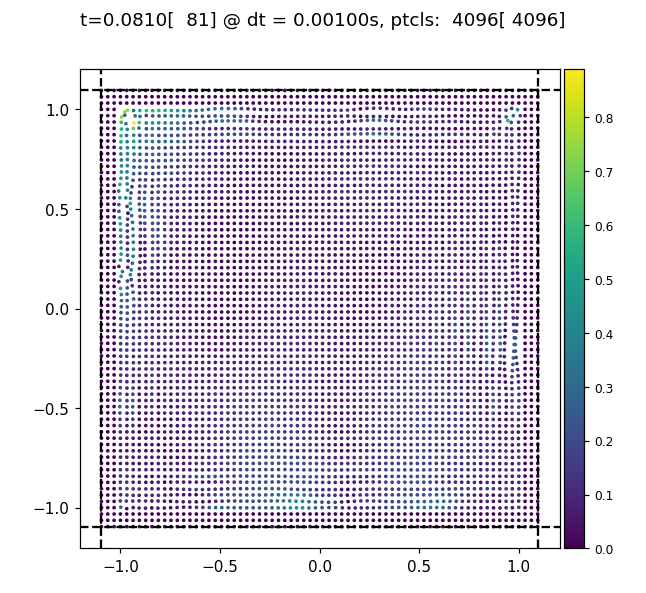

In [14]:
fig, axis = sphSimulation.createPlot(plotScale = 2, plotSolids = False, plotDomain = True)
state = sphSimulation.simulationState

positions = state['fluidPosition'].detach().cpu().numpy()
data = state['fluidDensity'].detach().cpu().numpy()

positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy()
# data2[:] = 0

# data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
# data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()

# data = state['residual'].detach().cpu().numpy()
# data = state['fluidAlpha'].detach().cpu().numpy()
# data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

positions = np.vstack((positions, positions2))
data = np.hstack((data, data2))

# positions = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
# data = sphSimulation.boundaryModule.fluidVolume.detach().cpu().numpy() 

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

# quiverData = state['fluidUpdate'].detach().cpu().numpy()
# qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
#                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
if 'densityErrors' in state and not 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
if 'divergenceErrors' in state and not 'densityErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
if 'densityErrors' in state and 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

fig.tight_layout()



In [13]:
# debugPrint(sphSimulation.boundaryModule.boundaryPressure)

In [14]:
# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# path = './output/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
# if not os.path.exists(path):
#     os.makedirs(path)

In [15]:
for i in tqdm(range(2000)):
    sphSimulation.integrate()
#     sphSimulation.timestep()
    if i  % 1 == 0:
        state = sphSimulation.simulationState
        positions = state['fluidPosition'].detach().cpu().numpy()

        positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
        
#         data = state['fluidDensity'].detach().cpu().numpy()
#         data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy()
        
        data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
        data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
#         data = torch.linalg.norm(state['fluidUpdate'], dim=1).detach().cpu().numpy()
        
#         data = state['fluidPressure'].detach().cpu().numpy()
#         data = sphSimulation.deltaSPH.pressure.detach().cpu().numpy()
#         data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

        positions = np.vstack((positions, positions2))
        data = np.hstack((data, data2))

        cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
        sc.set_offsets(positions)
        sc.set_array(data)


        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
        if 'densityErrors' in state and not 'divergenceErrors' in state:
            fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
        if 'divergenceErrors' in state and not 'densityErrors' in state:
            fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
        if 'densityErrors' in state and 'divergenceErrors' in state:
            fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))


        fig.canvas.draw()
        fig.canvas.flush_events()
#         imagePath = path + '%05d.png' % state['timestep']
#         plt.savefig(imagePath)

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
# debugPrint(sphSimulation.config['particle']['support'])
# debugPrint(sphSimulation.simulationState['fluidSupport'])

In [28]:
sphSimulation.outFile.close()
# debugPrint(sphSimulation.outFile.keys())

In [11]:
# fig, axis = sphSimulation.createPlot(plotScale = 2, plotSolids = False, plotDomain = False)
# state = sphSimulation.simulationState

# positions = state['fluidPosition'].detach().cpu().numpy()
# data = state['fluidDensity'].detach().cpu().numpy()

# positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
# data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

# # data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
# # data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()

# # positions = np.vstack((positions, positions2))
# # data = np.hstack((data, data2))

# # data = sphSimulation.DFSPH.fluidAlpha
# data = state['fluidPressure']

# # positions = positions2
# # data = data2

# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
# axis[0,0].axis('equal')

# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

# # quiverData = state['fluidUpdate'].detach().cpu().numpy()
# # qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
# #                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

# fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
# if 'densityErrors' in state and not 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
# if 'divergenceErrors' in state and not 'densityErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
# if 'densityErrors' in state and 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

# fig.tight_layout()



In [11]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    for i in range(1):
        with record_function("full Timestep"): 
            sphSimulation.integrate()
        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          full Timestep         0.73%       1.126ms        98.55%     151.014ms     151.014ms       0.000us         0.00%      79.950ms      79.950ms          -4 b        -268 b       1.11 Mb     -56.75 M